<a href="https://colab.research.google.com/github/webbigdata-jp/python_sample/blob/main/Stable_Diffusion_2_0_v768_image_2_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 無料版ColabでStable Diffusion 2.0 v Model(768版)でImage2ImageをするためのシンプルなColabファイル

---------

まずは左上の「ファイル」メニューより「ドライブにコピーを保存」を選んで、本ファイルをご自分のGoogleドライブ上にコピーして保存し、コピーした方のファイルをブックマークしてください。

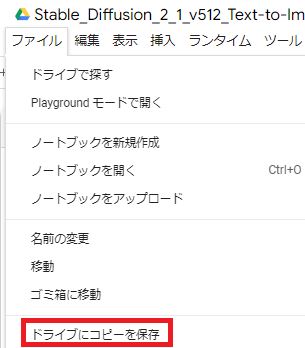

自分用に保存しておけば仮にファイルを壊してしまっても、もう一度コピーしてやり直す事ができます。  

なお、保存時に以下のような警告ウィンドウがでる事がありますが、本ファイルが信用できると思った場合は「このまま実行」を押してください。

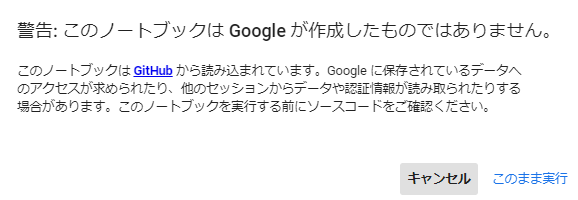


その後、左下の方に表示されている以下のマークを順番にクリックしていってください。

mark.png

１～４は起動毎に一度だけ押せば大丈夫です。５と６はプロンプトを変更する度に押す必要があります。



In [1]:
#@title １．必要なライブラリのインストール
%%capture
%%shell
pip install --upgrade git+https://github.com/huggingface/diffusers.git
pip install --upgrade transformers ftfy

In [2]:
#@title ２．Stable Diffusion 2.1モデルのダウンロード
#@markdown モデルは大きい(5Gバイト)のでダウンロードには５分近くの時間がかかる事があります。丁寧な作りになっているColabファイルでは毎回ダウンロードしなくて済むようにGoogle Driveにモデルを保存する作りになっている事があります。  

#@markdown しかし、Google Driveに保存するためには「Google Driveへの権限を与えても良いですか？」と表示されるウインドウに対して承認を行うステップが増えます。  

#@markdown 初心者には何か良く分からないウインドウに対して承認を押すのはハードルが上がると思うので毎回ダウンロードする作りにしています。  

#@markdown ライセンス等の使用条件は[配布サイト](https://huggingface.co/stabilityai/stable-diffusion-2-1)で確認してください。

%%capture
%%shell

mkdir stable-diffusion-2
cd stable-diffusion-2
wget https://huggingface.co/stabilityai/stable-diffusion-2/raw/main/model_index.json

mkdir vae
cd vae
wget https://huggingface.co/stabilityai/stable-diffusion-2/raw/main/vae/config.json
wget https://huggingface.co/stabilityai/stable-diffusion-2/resolve/main/vae/diffusion_pytorch_model.bin

cd ..

mkdir unet
cd unet
wget https://huggingface.co/stabilityai/stable-diffusion-2/raw/main/unet/config.json
wget https://huggingface.co/stabilityai/stable-diffusion-2/resolve/main/unet/diffusion_pytorch_model.bin
cd ..

mkdir tokenizer
cd tokenizer
wget https://huggingface.co/stabilityai/stable-diffusion-2/raw/main/tokenizer/merges.txt
wget https://huggingface.co/stabilityai/stable-diffusion-2/raw/main/tokenizer/special_tokens_map.json
wget https://huggingface.co/stabilityai/stable-diffusion-2/raw/main/tokenizer/vocab.json
wget https://huggingface.co/stabilityai/stable-diffusion-2/raw/main/tokenizer/tokenizer_config.json
cd ..

mkdir text_encoder
cd text_encoder
wget https://huggingface.co/stabilityai/stable-diffusion-2/raw/main/text_encoder/config.json
wget https://huggingface.co/stabilityai/stable-diffusion-2/resolve/main/text_encoder/pytorch_model.bin
cd ..

mkdir scheduler
cd scheduler
wget https://huggingface.co/stabilityai/stable-diffusion-2/raw/main/scheduler/scheduler_config.json
cd ..

mkdir feature_extractor
cd feature_extractor
wget https://huggingface.co/stabilityai/stable-diffusion-2/raw/main/feature_extractor/preprocessor_config.json
cd ..

cd ..

In [3]:
#@title ３．画像のアップロード
%%capture

from io import BytesIO
from PIL import Image

IMG_DIR = "/content"
file_path = ""

import os
from google.colab import files
import shutil



以下を実行すると「ファイル選択」というボタンが出るので押下して元となるファイルをアップロードしてください。

Saving ダウンロード.png to ダウンロード.png
move ダウンロード.png to /content/ダウンロード.png


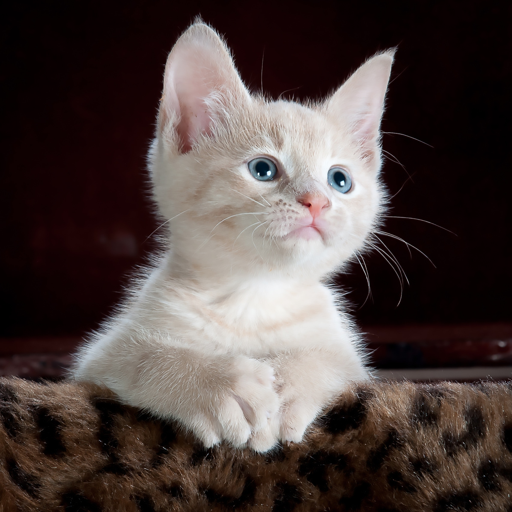

In [4]:
uploaded = files.upload()
for filename in uploaded.keys():
    dst_path = os.path.join(IMG_DIR, filename)
    print(f'move {filename} to {dst_path}')
    shutil.move(filename, dst_path)
    file_path = dst_path

init_img = Image.open(file_path).convert("RGB")
init_img = init_img.resize((512, 512))
init_img

In [ ]:
#@title ４．ライブラリのセットアップ
%%capture
%%shell

import inspect
import warnings
from typing import List, Optional, Union

import torch
from torch import autocast
from tqdm.auto import tqdm

from diffusers import StableDiffusionImg2ImgPipeline

device = "cuda"
model_path = "stable-diffusion-2"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    revision="fp16", 
    torch_dtype=torch.float16,
)
pipe = pipe.to(device)

In [6]:
#@title 画像生成用のプロンプトを設定
%%capture
%%shell
#@markdown 下記はフィンセント・ファン・ゴッホの作風で描く猫を指定しています。その他の有名な画家のスタイルは以下を参照してください。
#@markdown https://webbigdata.jp/post-14827
class_name = "A cat, by Vincent Van Gogh" #@param {type:"string"}


  0%|          | 0/37 [00:00<?, ?it/s]

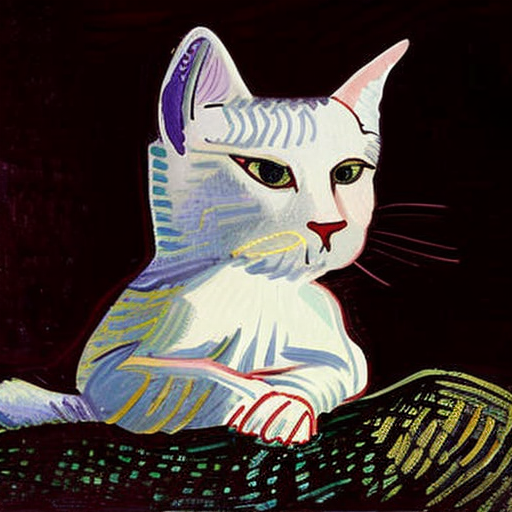

In [7]:
#@title ６．画像を生成
%%capture
%%shell

generator = torch.Generator(device=device).manual_seed(242)
with autocast("cuda"):
    image = pipe(prompt=prompt, image=init_img, strength=0.75, guidance_scale=7.5, generator=generator).images[0]

image
